In [2]:
import urllib

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import fastai
from fastai.imports import *
from fastai.vision import *

from torchvision.models import *
import pretrainedmodels

from utils import *
import sys

from fastai.callbacks.hooks import *

from fastai.callbacks.tracker import EarlyStoppingCallback
from fastai.callbacks.tracker import SaveModelCallback

In [2]:
# The metadata is indexed by the objid
df_INFO = pd.read_csv('./metadata.tsv', sep='\t', index_col=0)
print(df_INFO.shape)
df_INFO.head()

(73627, 4)


,M/L,L_g,distance_Mpc,galsize_kpc
SDSS_ID,,,,
1237662301367173202,2.398229,8.880467e+09,326.142854,48.655727
1237662301905813735,0.974585,7.007162e+09,293.571417,38.145197
1237662534360301834,0.678322,1.047446e+10,167.142861,30.677076
1237662500543987740,1.574709,1.748155e+10,282.000016,46.129129
1237662474235085097,1.076603,9.267565e+09,291.857134,43.540800


In [3]:
Base_dir =f'./128pix_10K/'

In [4]:
images = [file for file in os.listdir(Base_dir) if file[-3:] in ['jpg','png']]
names = [eval(file[:-4]) for file in images]

df_INFO =  df_INFO[df_INFO.index.isin(names)]
print(df_INFO.shape)
df_INFO.reset_index(inplace=True)


(20000, 4)


In [5]:
df_file = pd.DataFrame()
df_file['FileNames'] =  images
df_file['SDSS_ID'] = names
print(df_file.shape)
print(df_file.head())

(20000, 2)
                 FileNames              SDSS_ID
0  1237654601557737549.png  1237654601557737549
1  1237654604253233397.png  1237654604253233397
2  1237656241170874475.png  1237656241170874475
3  1237651537649533116.png  1237651537649533116
4  1237651272956903644.png  1237651272956903644


In [6]:
df_INFO = df_INFO.merge(df_file,on='SDSS_ID',how='left')
df_INFO['FILEPATH'] = df_INFO['FileNames'].apply(lambda x: Base_dir+'/'+x)

In [7]:
df_INFO.head()

,SDSS_ID,M/L,L_g,distance_Mpc,galsize_kpc,FileNames,FILEPATH
0,1237656496724836598,4.237423,7.537444e+10,509.571433,61.791850,1237656496724836598.png,./128pix_10K//1237656496724836598.png
1,1237656496726343835,0.611328,1.604082e+09,78.428574,9.510436,1237656496726343835.png,./128pix_10K//1237656496726343835.png
2,1237652944785244424,2.509877,1.915310e+10,207.857149,26.393140,1237652944785244424.png,./128pix_10K//1237652944785244424.png
3,1237657628429058617,4.778995,2.559318e+10,345.428575,59.167655,1237657628429058617.png,./128pix_10K//1237657628429058617.png
4,1237655108896096756,4.012120,6.102740e+10,664.285719,101.410065,1237655108896096756.png,./128pix_10K//1237655108896096756.png


In [8]:

tfms = get_transforms(max_rotate= 10.,max_zoom=1., max_lighting=0.20, do_flip=False,
                      max_warp=0., xtra_tfms=[flip_lr(), brightness(change=(0.3, 0.60), p=0.7), contrast(scale=(0.5, 2), p=0.7),
                                              crop_pad(size=600, padding_mode='border', row_pct=0.,col_pct=0.),
                                              rand_zoom(scale=(1.,1.5)), rand_crop(),
                                              perspective_warp(magnitude=(-0.1,0.1)),
                                              #jitter(magnitude=(-0.05,0.05), p=0.5),
                                              symmetric_warp(magnitude=(-0.1,0.1)) ])

In [9]:
data_stellar_image = ImageList.from_df(df_INFO, Base_dir, cols=['FileNames']).split_by_rand_pct(0.2, seed=42).label_from_df("M/L",label_cls=FloatList).transform(tfms, resize_method=ResizeMethod.CROP, padding_mode='border',size=128).databunch(bs=64*2,num_workers=0).normalize(imagenet_stats)

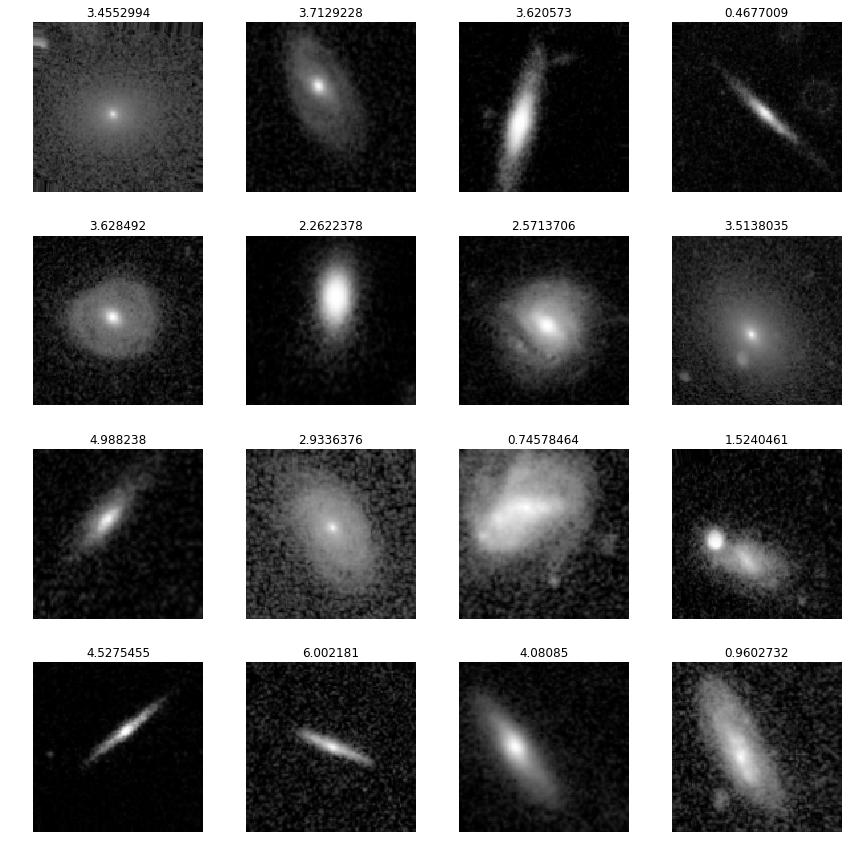

In [18]:
data_stellar_image.show_batch(4,figsize=(12,12))

In [32]:
opt_func = partial(optim.Adam, betas=(0.9,0.99), eps=1e-5)
class L1LossFlat(nn.SmoothL1Loss):
    def forward(self, in1:Tensor, target:Tensor) -> Rank0Tensor:
        return super().forward(in1.view(-1), target.view(-1))

In [34]:
arch = resnet152

In [35]:
learn = cnn_learner(data_stellar_image, arch, model_dir = "/home/ubuntu/quickstar/model",pretrained=True ,opt_func=opt_func, bn_wd=False, metrics=root_mean_squared_error,
               callback_fns=[ShowGraph]).mixup(stack_y=False, alpha=0.2)

learn.loss_func = L1LossFlat()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-02
Min loss divided by 10: 1.20E-02


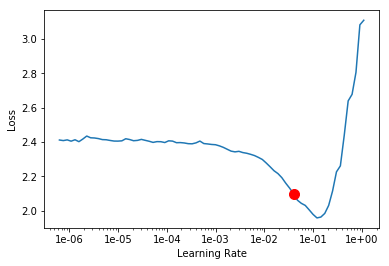

In [22]:
learn.freeze_to(-1)
learn.lr_find()
learn.recorder.plot(suggestion = True)

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,1.241898,0.538450,1.217311,05:09
1,0.584041,0.437151,1.065884,05:03
2,0.494574,0.429864,1.084056,04:45
3,0.436331,0.366178,0.975586,04:54
4,0.394938,0.355760,0.962934,04:50


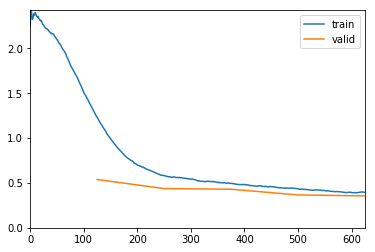

Better model found at epoch 0 with valid_loss value: 0.5384498238563538.
Better model found at epoch 1 with valid_loss value: 0.43715062737464905.
Better model found at epoch 2 with valid_loss value: 0.42986443638801575.
Better model found at epoch 3 with valid_loss value: 0.36617812514305115.
Better model found at epoch 4 with valid_loss value: 0.35576024651527405.


In [23]:
learn.fit_one_cycle(5, max_lr=slice(1e-2), wd=(1e-6, 1e-4, 1e-2), pct_start=0.5, callbacks=[SaveModelCallback(learn)])

In [24]:
learn.save('first_head_resnet34_304_1')
learn.load('first_head_resnet34_304_1');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 2.29E-05


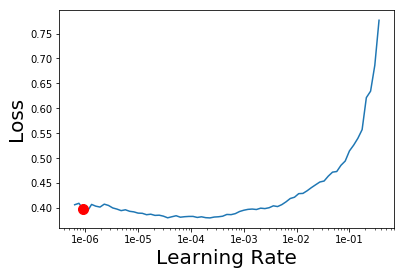

In [35]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion = True)

In [58]:
lr = 1e-2

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.355133,0.346588,0.952816,05:55
1,0.361737,0.328651,0.919010,05:50
2,0.358103,0.334590,0.943926,05:49
3,0.331364,0.313038,0.906246,06:04
4,0.307928,0.302945,0.888386,05:56


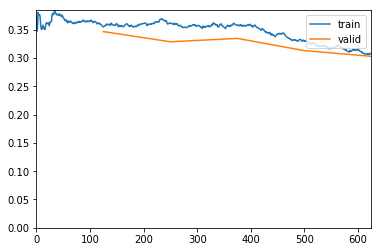

Better model found at epoch 0 with valid_loss value: 0.34658825397491455.
Better model found at epoch 1 with valid_loss value: 0.3286513686180115.
Better model found at epoch 3 with valid_loss value: 0.3130379617214203.
Better model found at epoch 4 with valid_loss value: 0.3029448986053467.


In [59]:
learn.fit_one_cycle(5, max_lr=slice(1e-5, lr/5), wd=(1e-6, 1e-4, 1e-2), 
                    callbacks=[SaveModelCallback(learn)], pct_start=0.5)

In [60]:
learn.save('first_head_resnet34_304_2')
learn.load('first_head_resnet34_304_2');

In [40]:
learn.export(load_path,"RESNET_STELAR_FINAL_304_2_best.pkl")

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type L1LossFlat. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


this Learner object self-destroyed - it still exists, but no longer usable


# Accuracy metric on validation set

In [62]:
p_val, y_val = learn.TTA()

# p_val,y_val = learn.get_preds(ds_type=DatasetType.Valid)

print(p_val.shape),print(y_val.shape)

pval_numpy = p_val.numpy()
y_val_numpy =  y_val.numpy()

print(pval_numpy.shape),print(y_val_numpy.shape)

torch.Size([4000, 1])
torch.Size([4000])
(4000, 1)
(4000,)


(None, None)

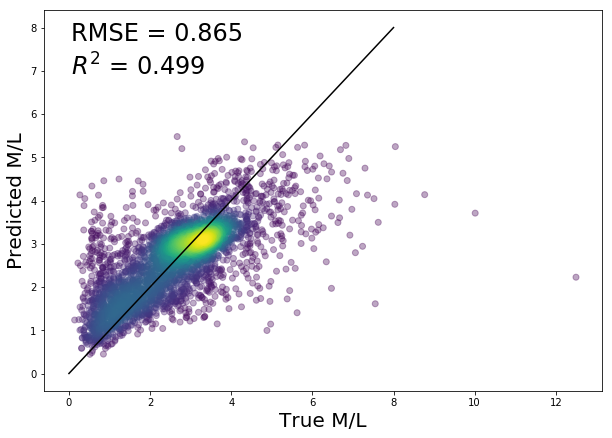

In [64]:
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

def estimate_density(x, y, **kwargs):
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy, **kwargs)
    z = kde(xy)
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    return x[idx], y[idx], z[idx]

def rmse(yt, yp):
    return np.sqrt(np.mean(np.square(yt - yp)))

def r2(yt, yp):
    ybar = np.mean(yt)
    return 1 - (np.sum(np.square(yt - yp)) / np.sum(np.square(yt - ybar)))

def plot_truevspred():
    y = y_val_numpy
    y_pred = pval_numpy[:,0]
    rmse_val = rmse(y, y_pred)
    r2_val = r2(y, y_pred)
    
    xc, yc, c = estimate_density(y, y_pred)
    plt.rcParams['axes.labelsize'] = 20
    plt.rcParams['font.size'] = 10
    plt.figure(figsize=(10, 7))
    plt.scatter(xc, yc, c=c, alpha=0.35)
    plt.xlabel('True M/L')
    plt.ylabel('Predicted M/L')
    plt.plot([0, 8], [0, 8], 'k-')
    ax = plt.gca()
    fontsize = 24
    plt.text(0.05, 0.92, f'RMSE = {rmse_val:.3f}', transform=ax.transAxes,
             fontsize=fontsize)
    plt.text(0.05, 0.83, f'$R^2$ = {r2_val:.3f}', transform=ax.transAxes,
             fontsize=fontsize)
    
plot_truevspred()

# Accuracy metric on Test set

In [10]:
test_dir =f'./128_test5K/'

In [11]:
df_test =  pd.read_csv(os.path.join(test_dir,"128_test5k.csv"))

In [25]:
data_test_stellar_image = ImageList.from_df(df_test, test_dir, cols=['FileNames']).split_by_rand_pct(1.0, seed=42).label_from_df("M/L",label_cls=FloatList).transform(tfms, resize_method=ResizeMethod.CROP, padding_mode='border',size=128).databunch(bs=64*2,num_workers=0).normalize(imagenet_stats)

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/fastai/data_block.py:454: UserWarning: Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.
  warn("Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.")


In [44]:
learn.data = data_test_stellar_image

In [46]:
p_test, y_test = learn.TTA()

# p_val,y_val = learn.get_preds(ds_type=DatasetType.Valid)

print(p_test.shape),print(y_test.shape)

ptest_numpy = p_test.numpy()
y_test_numpy =  y_test.numpy()

print(ptest_numpy.shape),print(y_test_numpy.shape)

torch.Size([5000, 1])
torch.Size([5000])
(5000, 1)
(5000,)


(None, None)

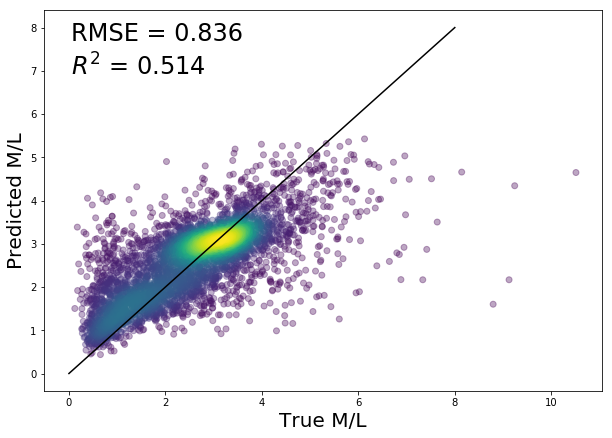

In [47]:
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

def estimate_density(x, y, **kwargs):
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy, **kwargs)
    z = kde(xy)
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    return x[idx], y[idx], z[idx]

def rmse(yt, yp):
    return np.sqrt(np.mean(np.square(yt - yp)))

def r2(yt, yp):
    ybar = np.mean(yt)
    return 1 - (np.sum(np.square(yt - yp)) / np.sum(np.square(yt - ybar)))

def plot_truevspred():
    y = y_test_numpy
    y_pred = ptest_numpy[:,0]
    rmse_val = rmse(y, y_pred)
    r2_val = r2(y, y_pred)
    
    xc, yc, c = estimate_density(y, y_pred)
    plt.rcParams['axes.labelsize'] = 20
    plt.rcParams['font.size'] = 10
    plt.figure(figsize=(10, 7))
    plt.scatter(xc, yc, c=c, alpha=0.35)
    plt.xlabel('True M/L')
    plt.ylabel('Predicted M/L')
    plt.plot([0, 8], [0, 8], 'k-')
    ax = plt.gca()
    fontsize = 24
    plt.text(0.05, 0.92, f'RMSE = {rmse_val:.3f}', transform=ax.transAxes,
             fontsize=fontsize)
    plt.text(0.05, 0.83, f'$R^2$ = {r2_val:.3f}', transform=ax.transAxes,
             fontsize=fontsize)
    
plot_truevspred()